In [1]:
#step1
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

print("hello world")



hello world


In [2]:

#step2
data_dir  = 'C:/Users/rajam/OneDrive/Desktop/imgdataset/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:

#step 3
#Responsible for converting images (resizing and adding it to folder)
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)
print("completed step 3")


completed step 3


In [6]:

#step 4
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

print("completed step 4")


completed step 4


Label: cardboard (Class No: 0)
completed step 5


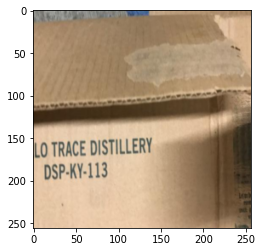

In [5]:

#step 5
img, label = dataset[12]
show_sample(img, label)
print("completed step 5")



In [7]:
#step 6
random_seed = 42
torch.manual_seed(random_seed)
print("completed step 6")


completed step 6


In [8]:

#step 7
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)
print("completed step 7")


completed step 7


Label: plastic (Class No: 4)


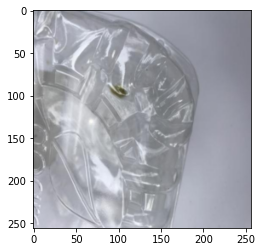

In [44]:
# just checking

img, label = test_ds[12]
show_sample(img, label)

In [9]:

#step 8
from torch.utils.data.dataloader import DataLoader
batch_size = 32
print("completed step 8")


completed step 8


In [10]:


#step 9
#Training and Validation part
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
print("completed step 9")


completed step 9


In [11]:

#step 10
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

print("completed step 10")


completed step 10


completed step 11


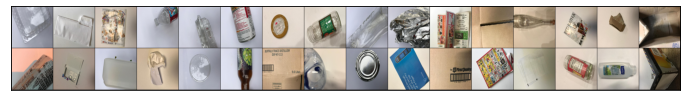

In [12]:

#step 11
show_batch(train_dl)
print("completed step 11")

In [13]:
#step 12
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
        
print("step 12 completed")

step 12 completed


In [14]:
#step 13

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()


print("step 13 completed")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\rajam/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


step 13 completed


In [15]:
#step 14
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    
    
print("step 14 completed")

step 14 completed


In [17]:
#step 15

device = get_default_device()
print(device)
print("step 15 completed")

cpu
step 15 completed


In [19]:
#step 16
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)
print(to_device(model, device))
print("step 16 completed")

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [20]:
#step 17
#training the model

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

print("step 17 completed")

step 17 completed


In [22]:
model = to_device(ResNet(), device)

print("step 18 completed")

step 18 completed


In [24]:
evaluate(model, val_dl)

print("step 19 completed")

step 19 completed


In [26]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

print("step 20 completed")

Epoch 1: train_loss: 1.2073, val_loss: 1.1690, val_acc: 0.9115
Epoch 2: train_loss: 1.1023, val_loss: 1.1321, val_acc: 0.9323
Epoch 3: train_loss: 1.0719, val_loss: 1.1180, val_acc: 0.9323
Epoch 4: train_loss: 1.0618, val_loss: 1.1176, val_acc: 0.9358
Epoch 5: train_loss: 1.0581, val_loss: 1.1321, val_acc: 0.9219
Epoch 6: train_loss: 1.0614, val_loss: 1.1201, val_acc: 0.9323
Epoch 7: train_loss: 1.0564, val_loss: 1.1052, val_acc: 0.9462
Epoch 8: train_loss: 1.0531, val_loss: 1.1092, val_acc: 0.9271
step 20 completed


step 21 completed


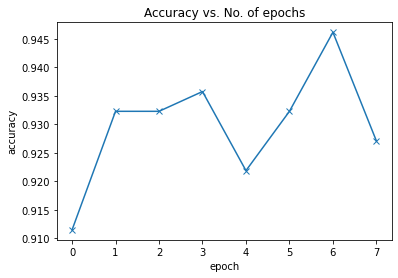

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

print("step 21 completed")

None
step 22 completed


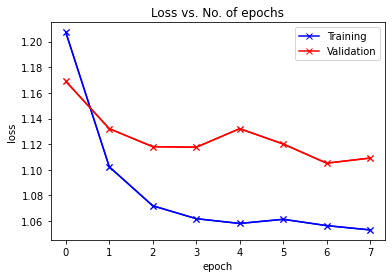

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)
print(plot_losses(history))

print("step 22 completed")

In [30]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


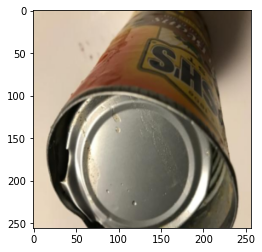

In [31]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


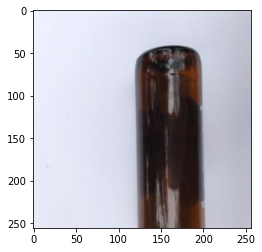

In [32]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


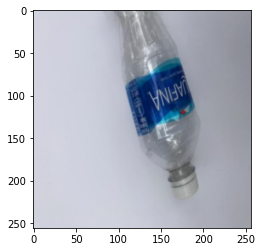

In [33]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [35]:
#Predicting External Images
#refer https://www.kaggle.com/sudarshansrinivasan/garbage-classify-95-accuracy-scr-p-2
#model accuracy calculation  

print(len(train_ds))
print(len(val_ds)) 
print(len(test_ds))

1593
176
758


In [36]:
loaded_model = model


In [60]:
from PIL import Image
from pathlib import Path
"""
def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")
"""
def predict():
    
    #predictions = [predict_image(x,loaded_model) for x in test_ds]
    for y in range(0,len(test_ds)):
        img, label = test_ds[y]
        show_sample(img, label)
        
        #predictions[y] = predict_image(img, loaded_model)
        print("The image resembles", predict_image(img, loaded_model) + ".")
        #print(predictions[y])
        
    #return predictions

        

In [47]:
#predict()
#error

In [68]:
#predict_image(test_ds[12], loaded_model)
#error
img, label = test_ds[12]
print(label)
print(dataset.classes[label])

4
plastic


Label: paper (Class No: 3)
The image resembles paper.
Label: plastic (Class No: 4)
The image resembles plastic.
Label: cardboard (Class No: 0)
The image resembles cardboard.
Label: metal (Class No: 2)
The image resembles metal.
Label: plastic (Class No: 4)
The image resembles plastic.
Label: paper (Class No: 3)
The image resembles paper.
Label: plastic (Class No: 4)
The image resembles plastic.
Label: cardboard (Class No: 0)
The image resembles cardboard.
Label: plastic (Class No: 4)
The image resembles plastic.
Label: glass (Class No: 1)
The image resembles glass.
Label: metal (Class No: 2)
The image resembles metal.
Label: paper (Class No: 3)
The image resembles paper.
Label: plastic (Class No: 4)
The image resembles plastic.
Label: cardboard (Class No: 0)
The image resembles cardboard.
Label: glass (Class No: 1)
The image resembles metal.
Label: glass (Class No: 1)
The image resembles glass.
Label: glass (Class No: 1)
The image resembles glass.
Label: metal (Class No: 2)
The image r

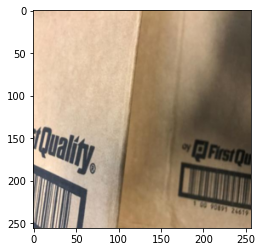

In [61]:
predict()

In [69]:
"""
Accuracy = (no. of correct predictions/total predictions)*100
"""
actual = []
predicted = []

#print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
def accuracy_calculation():
    correct_prediction_count = 0
    incorrect_prediction_count = 0

    #predictions = [predict_image(x,loaded_model) for x in test_ds]
    for y in range(0,len(test_ds)):
        img, label = test_ds[y]
        show_sample(img, label)
        actual = dataset.classes[label]
        prediction = predict_image(img, loaded_model)
        #print("The image resembles", predict_image(img, loaded_model) + ".")
        #print(predictions[y])
        if(actual == prediction):
            correct_prediction_count = correct_prediction_count+1
        else:
            incorrect_prediction_count = incorrect_prediction_count+1
        
    accuracy = (correct_prediction_count/len(test_ds))*100
    print("correct_prediction_count : ",correct_prediction_count)
    print("incorrect_prediction_count : ",incorrect_prediction_count)
    print("total test data : ",len(test_ds))
    
    print("Accuracy : ",accuracy)
        
    
            
    #return predictions


Label: paper (Class No: 3)
Label: plastic (Class No: 4)
Label: cardboard (Class No: 0)
Label: metal (Class No: 2)
Label: plastic (Class No: 4)
Label: paper (Class No: 3)
Label: plastic (Class No: 4)
Label: cardboard (Class No: 0)
Label: plastic (Class No: 4)
Label: glass (Class No: 1)
Label: metal (Class No: 2)
Label: paper (Class No: 3)
Label: plastic (Class No: 4)
Label: cardboard (Class No: 0)
Label: glass (Class No: 1)
Label: glass (Class No: 1)
Label: glass (Class No: 1)
Label: metal (Class No: 2)
Label: cardboard (Class No: 0)
Label: metal (Class No: 2)
Label: glass (Class No: 1)
Label: plastic (Class No: 4)
Label: metal (Class No: 2)
Label: glass (Class No: 1)
Label: cardboard (Class No: 0)
Label: plastic (Class No: 4)
Label: plastic (Class No: 4)
Label: metal (Class No: 2)
Label: glass (Class No: 1)
Label: glass (Class No: 1)
Label: cardboard (Class No: 0)
Label: cardboard (Class No: 0)
Label: trash (Class No: 5)
Label: plastic (Class No: 4)
Label: paper (Class No: 3)
Label: pl

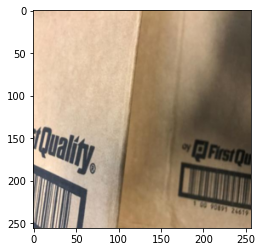

In [70]:
accuracy_calculation()

In [ ]:
#external image
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")